# Problem 3

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist, mnist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

def calculate_pairwise_distance(X_test, X_test_decoded):
    index_distance_map = []

    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    X_test_decoded_flattened = np.array(X_test_decoded).reshape(X_test_decoded.shape[0], -1)

    print('pairwise distances example 1')
    for i in range(len(X_test_decoded)):
        similarity_value = cosine_similarity([X_test_decoded_flattened[i]], [X_test_flattened[i]])[0][0]
        index_distance_map.append((i, similarity_value))
    return index_distance_map

def extract_top_100_features(model):
    """ Extract top 100 features per label class. """

    feature_indices = []

    # print('top 100 features for each label\n')
    for i in range(len(lr.coef_)):
        # print('label', i, end=' - ')
        # print(np.argsort(np.absolute(lr.coef_[i, :]))[-100:])
        top_100_features = np.argsort(np.absolute(lr.coef_[i, :]))[-100:]
        for feature_index in top_100_features:
            feature_indices.append(feature_index)
        return feature_indices

## FASHION MNIST

In [3]:
(X_train, y_train) , (X_test, y_test)= fashion_mnist.load_data()

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [4]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=losses.MeanSquaredError()
)

In [5]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [6]:
autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=6,
    validation_data=(X_val, X_val)
)

Epoch 1/6
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0430 - val_loss: 0.0141
Epoch 2/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0130 - val_loss: 0.0111
Epoch 3/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 4/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 5/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 6/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0093 - val_loss: 0.0092


In [7]:
X_train_encoded = autoencoder.encoder(X_train)
X_test_encoded = autoencoder.encoder(X_test)
X_train_decoded = autoencoder.decoder(X_train_encoded)
X_test_decoded = autoencoder.decoder(X_test_encoded)

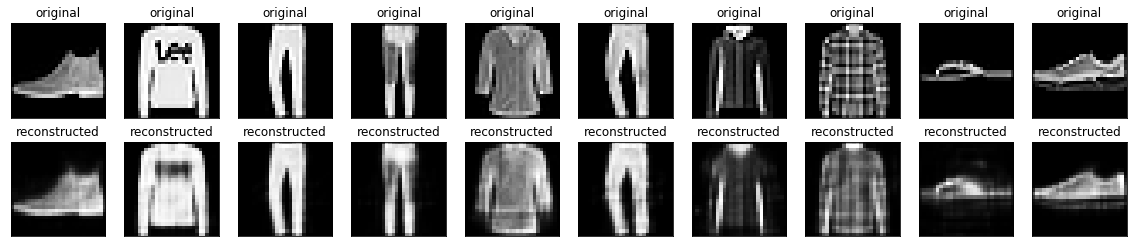

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
lr = LogisticRegression(max_iter=300).fit(X_train_encoded, y_train)
predictions = lr.predict(X_test_encoded)
print(accuracy_score(y_test, predictions))

0.8352
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
index_distance_map = calculate_pairwise_distance(X_test, X_test_decoded)
sorted_by_distance = sorted(index_distance_map, key=lambda tup: tup[1])
print([tuple[0] for tuple in sorted_by_distance[:20]])

pairwise distances example 1
[129, 1090, 9199, 1846, 3466, 2223, 690, 2961, 5584, 6428, 1439, 5511, 3703, 8626, 3333, 6752, 3138, 3047, 5828, 6023]


In [11]:
related_words_indices = extract_top_100_features(lr)
new_features = np.array(X_train_encoded)[:, related_words_indices]
print('cosine similarity')
print(cosine_similarity(new_features))
print('\neuclidean distance')
print(euclidean_distances(new_features))

cosine similarity
[[0.99999994 0.7287832  0.76658916 ... 0.718621   0.7046093  0.8482936 ]
 [0.7287832  0.99999994 0.7816206  ... 0.6707431  0.7485047  0.6609804 ]
 [0.76658916 0.7816206  1.0000001  ... 0.75929415 0.87829894 0.7351893 ]
 ...
 [0.718621   0.6707431  0.75929415 ... 0.99999994 0.68074495 0.79543996]
 [0.7046093  0.7485047  0.87829894 ... 0.68074495 1.0000002  0.624888  ]
 [0.8482936  0.6609804  0.7351893  ... 0.79543996 0.624888   0.9999997 ]]

euclidean distance
[[ 0.        25.174673  25.77859   ... 26.857153  25.808846  20.628597 ]
 [25.174673   0.        20.718739  ... 23.28612   20.488588  23.324787 ]
 [25.77859   20.718739   0.        ... 11.47955   11.394451  15.6001005]
 ...
 [26.857153  23.28612   11.47955   ...  0.        16.683058  14.050983 ]
 [25.808846  20.488588  11.394451  ... 16.683058   0.        19.807516 ]
 [20.628597  23.324787  15.6001005 ... 14.050983  19.807516   0.       ]]


## MNIST

In [18]:
(X_train, y_train) , (X_test, y_test)= mnist.load_data()

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [19]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [20]:
autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=6,
    validation_data=(X_val, X_val)
)

Epoch 1/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 2/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 3/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 4/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/6
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0044 - val_loss: 0.0044


In [21]:
X_train_encoded = autoencoder.encoder(X_train)
X_test_encoded = autoencoder.encoder(X_test)
X_train_decoded = autoencoder.decoder(X_train_encoded)
X_test_decoded = autoencoder.decoder(X_test_encoded)

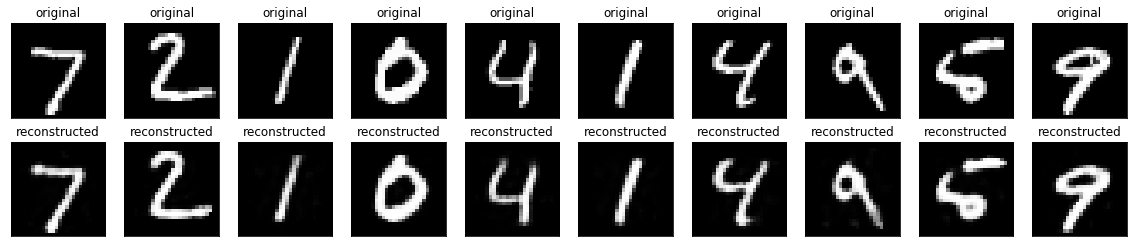

In [22]:
plt.figure(figsize=(20, 4))

n = 10
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(X_test_decoded[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
lr = LogisticRegression(max_iter=300).fit(X_train_encoded, y_train)
predictions = lr.predict(X_test_encoded)
print(accuracy_score(y_test, predictions))

0.9172
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
index_distance_map = calculate_pairwise_distance(X_test, X_test_decoded)
sorted_by_distance = sorted(index_distance_map, key=lambda tup: tup[1])
print([tuple[0] for tuple in sorted_by_distance[:20]])

pairwise distances example 1
[1090, 129, 690, 9199, 6428, 2223, 3466, 1846, 8626, 5584, 1439, 3333, 3138, 6752, 8530, 5828, 3047, 3680, 1521, 5511]


In [22]:
related_words_indices = extract_top_100_features(lr)
new_features = np.array(X_train_encoded)[:, related_words_indices]
print('cosine similarity')
print(cosine_similarity(new_features))
print('\neuclidean distance')
print(euclidean_distances(new_features))

cosine similarity
[[0.99999976 0.70603436 0.7726951  ... 0.7439611  0.72335404 0.82768685]
 [0.70603436 1.         0.7788685  ... 0.65860546 0.7302224  0.63079935]
 [0.7726951  0.7788685  1.0000001  ... 0.7468007  0.8809332  0.7359155 ]
 ...
 [0.7439611  0.65860546 0.7468007  ... 1.0000001  0.6847886  0.82573843]
 [0.72335404 0.7302224  0.8809332  ... 0.6847886  0.99999994 0.6591983 ]
 [0.82768685 0.63079935 0.7359155  ... 0.82573843 0.6591983  1.0000001 ]]

euclidean distance
[[ 0.       25.659637 24.409887 ... 25.047623 24.245428 20.588259]
 [25.659637  0.       21.31666  ... 24.08801  21.574226 24.629875]
 [24.409887 21.31666   0.       ... 11.909565 11.075641 15.234104]
 ...
 [25.047623 24.08801  11.909565 ...  0.       16.43096  12.816526]
 [24.245428 21.574226 11.075641 ... 16.43096   0.       18.560907]
 [20.588259 24.629875 15.234104 ... 12.816526 18.560907  0.      ]]


## SPAMBASE

In [16]:
def parse_spambase_dataset(filename):
    """ Exclusive for spambase data. """

    spambase_data, spambase_labels = [], []
    with open(filename) as f:
        line = f.readline()
        while line:
            elements = [float(v) for v in line.split(',')]
            vectors, label = elements[:-1], int(elements[-1])
            spambase_data.append(vectors)
            spambase_labels.append(label)
            line = f.readline()
    return np.array(spambase_data), spambase_labels

In [17]:
spambase_data, spambase_labels = parse_spambase_dataset('spambase.data')
spambase_data, spambase_labels = shuffle(spambase_data, spambase_labels)

In [18]:
X_train, y_train = spambase_data[:4000], spambase_labels[:4000]
X_test, y_test = spambase_data[4000:], spambase_labels[4000:]
LABELS = set(y_train)
print('X_train shape -', X_train.shape)
print('y_train shape -', len(y_train))
print('X_test shape -', X_test.shape)
print('y_test shape -', len(y_test))
print('Labels -', LABELS)

X_train shape - (4000, 57)
y_train shape - 4000
X_test shape - (601, 57)
y_test shape - 601
Labels - {0, 1}


In [19]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(57, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [20]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=losses.MeanSquaredError()
)

In [21]:
autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
)

Epoch 1/20
125/125 [==============================] - 0s 718us/step - loss: 6771.7662
Epoch 2/20
125/125 [==============================] - 0s 627us/step - loss: 9932.3159
Epoch 3/20
125/125 [==============================] - 0s 615us/step - loss: 9336.7819
Epoch 4/20
125/125 [==============================] - 0s 640us/step - loss: 11032.4529
Epoch 5/20
125/125 [==============================] - 0s 592us/step - loss: 7920.0076
Epoch 6/20
125/125 [==============================] - 0s 612us/step - loss: 10080.1028
Epoch 7/20
125/125 [==============================] - 0s 678us/step - loss: 11055.5925
Epoch 8/20
125/125 [==============================] - 0s 701us/step - loss: 8853.2576
Epoch 9/20
125/125 [==============================] - 0s 616us/step - loss: 9957.0514


In [22]:
X_train_encoded = autoencoder.encoder(X_train)
X_test_encoded = autoencoder.encoder(X_test)
X_train_decoded = autoencoder.decoder(X_train_encoded)
X_test_decoded = autoencoder.decoder(X_test_encoded)

In [10]:
lr = LogisticRegression(max_iter=300).fit(X_train_encoded, y_train)
predictions = lr.predict(X_test_encoded)
print(accuracy_score(y_test, predictions))

0.9051580698835274
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
cosine_similarity(X_train, X_train_decoded)

array([[0.46634826, 0.48452631, 0.50574299, ..., 0.54308291, 0.35003717,
        0.37761549],
       [0.49884761, 0.52553047, 0.54885134, ..., 0.58166456, 0.37524222,
        0.40415315],
       [0.57760677, 0.71105405, 0.74671236, ..., 0.58725592, 0.41799363,
        0.44530953],
       ...,
       [0.46554865, 0.48939609, 0.50922335, ..., 0.79760282, 0.41123746,
        0.54941166],
       [0.53390551, 0.55090534, 0.56416296, ..., 0.62053147, 0.45808687,
        0.46013023],
       [0.53879556, 0.5504635 , 0.56015171, ..., 0.61981811, 0.42272727,
        0.50174865]])

In [11]:
index_distance_map = calculate_pairwise_distance(X_test, X_test_decoded)
sorted_by_distance = sorted(index_distance_map, key=lambda tup: tup[1])
print([tuple[0] for tuple in sorted_by_distance[:20]])

pairwise distances example 1
[192, 311, 440, 222, 88, 274, 454, 216, 461, 128, 367, 89, 589, 596, 581, 446, 295, 336, 224, 352]


In [24]:
# related_words_indices = extract_top_100_features(lr)
# new_features = np.array(X_train_encoded)[:, related_words_indices]
# print('cosine similarity')
# print(cosine_similarity(new_features))
# print('\neuclidean distance')
# print(euclidean_distances(new_features))

## 20NG

In [4]:
vectorizer = TfidfVectorizer()

X_train = fetch_20newsgroups(subset='train')
X_test = fetch_20newsgroups(subset='test')
y_train = X_train.target
y_test = X_test.target

LABELS = set(y_train)

X_train = vectorizer.fit_transform(X_train.data).todense()
X_test = vectorizer.transform(X_test.data).todense()
X_val = X_train[-2000:]
y_val = y_train[-2000:]
print('X_train shape -', X_train.shape)
print('y_train shape -', y_train.shape)
print('X_test shape -', X_test.shape)
print('y_test shape -', y_test.shape)
print('Labels -', LABELS)

X_train shape - (11314, 130107)
y_train shape - (11314,)
X_test shape - (7532, 130107)
y_test shape - (7532,)
Labels - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [5]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'),
        layers.Dense(latent_dim // 2, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(latent_dim // 2, activation="relu"),
        layers.Dense(latent_dim, activation="relu"),
        layers.Dense(X_train.shape[1], activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
latent_dim = 5000

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=losses.MeanSquaredError()
)

autoencoder.fit(
X_train, X_train,
shuffle=True,
epochs=6,
batch_size=128,
callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1),
validation_data=(X_val, X_val)
)

X_train_encoded = autoencoder.encoder(X_train)
X_test_encoded = autoencoder.encoder(X_test)
X_train_decoded = autoencoder.decoder(X_train_encoded)
X_test_decoded = autoencoder.decoder(X_test_encoded)

Epoch 1/6
16/16 [==============================] - 35s 2s/step - loss: 0.2317 - val_loss: 2.9310e-05
Epoch 2/6
16/16 [==============================] - 29s 2s/step - loss: 2.9310e-05 - val_loss: 2.9310e-05
Epoch 3/6
16/16 [==============================] - 28s 2s/step - loss: 2.9310e-05 - val_loss: 2.9310e-05


In [8]:
lr = LogisticRegression().fit(X_train_encoded, y_train)
predictions = lr.predict(X_test_encoded)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.6755358462675536
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
confusion_matrix(y_test, predictions)

array([[216,  61,  30,  12],
       [ 30, 332,  27,   0],
       [ 25,  63, 306,   0],
       [ 90,  57,  44,  60]])

In [10]:
related_words_indices = extract_top_100_features(lr)
new_features = np.array(X_train_encoded)[:, related_words_indices]
print('cosine similarity')
print(cosine_similarity(new_features))
print('\neuclidean distance')
print(euclidean_distances(new_features))

cosine similarity
[[1.0000002  0.9999546  0.9999342  ... 0.99994713 0.99995565 0.99996406]
 [0.9999546  0.9999998  0.99993974 ... 0.9999473  0.99995935 0.9999509 ]
 [0.9999342  0.99993974 0.99999994 ... 0.9999347  0.99993765 0.99995095]
 ...
 [0.99994713 0.9999473  0.9999347  ... 1.0000001  0.9999496  0.99994683]
 [0.99995565 0.99995935 0.99993765 ... 0.9999496  0.99999994 0.9999606 ]
 [0.99996406 0.9999509  0.99995095 ... 0.99994683 0.9999606  0.99999994]]

euclidean distance
[[0.         0.2815999  3.197188   ... 2.6919816  2.8260357  0.6191708 ]
 [0.2815999  0.         3.452761   ... 2.947701   2.5702572  0.37566927]
 [3.197188   3.452761   0.         ... 0.5163034  6.01947    3.8064353 ]
 ...
 [2.6919816  2.947701   0.5163034  ... 0.         5.514152   3.3016915 ]
 [2.8260357  2.5702572  6.01947    ... 5.514152   0.         2.216538  ]
 [0.6191708  0.37566927 3.8064353  ... 3.3016915  2.216538   0.        ]]


In [43]:
def calculate_pairwise_distance(X_test, X_test_decoded):
    index_distance_map = []

    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    X_test_decoded_flattened = np.array(X_test_decoded).reshape(X_test_decoded.shape[0], -1)

    print('pairwise distances example 1')
    for i in range(len(X_test_decoded)):
        similarity_value = cosine_similarity([X_test_encoded[i]])[0][0]
        index_distance_map.append((i, similarity_value))
    return index_distance_map

In [44]:
index_distance_map = calculate_pairwise_distance(X_test, X_test_decoded)
sorted_by_distance = sorted(index_distance_map, key=lambda tup: tup[1])
print([tuple[0] for tuple in sorted_by_distance[:20]])

pairwise distances example 1
[516, 751, 996, 14, 421, 268, 312, 335, 460, 557, 614, 641, 782, 881, 1006, 1069, 1203, 24, 67, 149]


In [4]:
accuracies = []

for latent_dim in [5, 10, 20, 100, 200, 500, 1000, 2000, 5000]:
    autoencoder = Autoencoder(latent_dim)

    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=losses.MeanSquaredError()
    )

    autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=6,
    batch_size=128,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1),
    validation_data=(X_val, X_val)
    )

    X_train_encoded = autoencoder.encoder(X_train)
    X_test_encoded = autoencoder.encoder(X_test)

    lr = LogisticRegression().fit(X_train_encoded, y_train)
    predictions = lr.predict(X_test_encoded)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    print('accuracy score', accuracy)

Epoch 1/6
16/16 [==============================] - 2s 97ms/step - loss: 0.2490 - val_loss: 0.2464
Epoch 2/6
16/16 [==============================] - 1s 49ms/step - loss: 0.2455 - val_loss: 0.2426
Epoch 3/6
16/16 [==============================] - 1s 48ms/step - loss: 0.2415 - val_loss: 0.2375
Epoch 4/6
16/16 [==============================] - 1s 51ms/step - loss: 0.2355 - val_loss: 0.2279
Epoch 5/6
16/16 [==============================] - 1s 44ms/step - loss: 0.2242 - val_loss: 0.2101
Epoch 6/6
16/16 [==============================] - 1s 42ms/step - loss: 0.2039 - val_loss: 0.1812
accuracy score 0.4153732446415373
Epoch 1/6
16/16 [==============================] - 1s 65ms/step - loss: 0.2490 - val_loss: 0.2463
Epoch 2/6
16/16 [==============================] - 1s 49ms/step - loss: 0.2454 - val_loss: 0.2421
Epoch 3/6
16/16 [==============================] - 1s 50ms/step - loss: 0.2406 - val_loss: 0.2344
Epoch 4/6
16/16 [==============================] - 1s 50ms/step - loss: 0.2309 - val

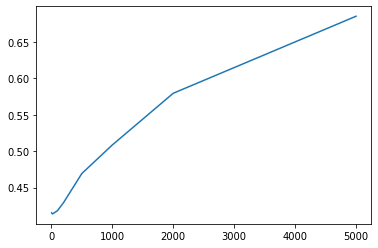

In [6]:
plt.plot([5, 10, 20, 100, 200, 500, 1000, 2000, 5000], accuracies)